# FRB 180916

This notebook is meant to outline how the BatAnalysis Tool can be used alongside swifttools to query, download, and analyze BAT GUANO data. 

Here, we will be querying for BAT GUANO data that was triggered by an FRB. We filter out the data to select one where FRB 180916.J0158+65 is in the BAT FOV. Then, we use the BatAnalysis Tools to look at the lightcurve and produce flux upper limits for the FRB in the 15-150 keV range. 

Additional information on the BAT GUANO system can be found here: [https://arxiv.org/pdf/2005.01751](https://arxiv.org/pdf/2005.01751) and here: [https://www.swift.psu.edu/guano/](https://www.swift.psu.edu/guano/)

First, lets import the packages that we will need:

In [1]:
import xspec
import batanalysis as ba
from swifttools.swift_too import GUANO, ObsQuery
import swiftbat

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from pathlib import Path
from astropy.io import fits
from astropy.time import Time, TimeDelta
import astropy.units as u
from astropy.coordinates import SkyCoord
import datetime
import os


Now, we will use the swiftbat package to create an object that holds the coordinate information for the FRB of interest.

In [2]:
object_name = "FRB 180916.J0158+65"

object_location = swiftbat.simbadlocation(object_name)
object_location=SkyCoord(ra=object_location[0]*u.deg, dec=object_location[1]*u.deg)

object_batsource = swiftbat.source(
    ra=object_location.ra.deg, dec=object_location.dec.deg, name=object_name
)


We can now, run a query for the first 300 FRB triggered GUANO datasets. 

***NOTE: Since the GUANO system is constantly running and getting BAT data for different triggers, the observation ID that gets analyzed for you in running this notebook will be different from what was originally analyzed here.***

In [3]:
guano=GUANO(triggertype="FRB", limit=300)
query=ObsQuery(obsid=[i.obsid for i in guano])

With our data queried, we need to filter out data where the FRB is not in the BAT FOV. 

We first do this by calculating the partial coding exposure of the FRB on the BAT detector plane (ie what is the area of the BAT detector plane that was illuminated by the FRB's point in the sky)

In [4]:
exposures = np.array(
    [object_batsource.exposure(ra=i.ra,
                               dec=i.dec, 
                               roll=i.roll)[0]
        for i in query
    ])
print(exposures)

[   0.            0.            0.            0.            0.
    0.         1099.06421105    0.            0.            0.
    0.            0.            0.            0.            0.
 4363.9596     4363.9596        0.            0.         4084.80727588
   56.79087144    0.            0.            0.            0.
    0.            0.         3615.75182232  131.44835059    0.
 3787.7621798     0.            0.            0.           98.05487582
    0.            0.          170.39591445    0.         3607.39463455
    0.            0.            0.         1904.52967258  292.31099611
 1819.60710488  315.19973283 3814.97160177    0.            0.
    0.            0.            0.            0.            0.
    0.         1548.62136364 2714.5126306  2707.80566887 2691.35495889
 2692.25683036    0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.         

Now, we can select the first GUANO dataset where the partial coding is $\gtrsim 19\%$. We also extract the trigger time of the FRB so we can use that as a T0 in our lightcurve and spectrum. 

In [5]:
minexposure = 1000  # cm^2 after cos adjust
sel_guano=np.array(query)[np.where(exposures > minexposure)[0]][0]
triggertime=guano[int(np.where([int(sel_guano.obsid)==int(i.obsid) for i in guano])[0])].triggertime
print(sel_guano)

+---------------------+---------------------+-------------+--------------------+--------------+--------------+
|          Begin Time |            End Time | Target Name | Observation Number | Exposure (s) | Slewtime (s) |
+---------------------+---------------------+-------------+--------------------+--------------+--------------+
| 2024-01-17 16:50:27 | 2024-01-17 16:56:25 |             |        01209406000 |          340 |           18 |
+---------------------+---------------------+-------------+--------------------+--------------+--------------+


/var/folders/t4/r1b0srk10n335yds5g1g053c8nkvkq/T/ipykernel_7453/3230960228.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


After finding the data that we want with the swiftools package, we can easily download it. We first specify where we will be downloading the data and doing our analysis in this notebook using our usual `ba.datadir` call. Then, we download the obsid of the GUANO dataset that we are interested in. 

In [6]:
tmp_download_dir="/tmp/batdata/download_examples"

ba.datadir(tmp_download_dir, mkdir=True)

download = ba.download_swiftdata(observations=sel_guano.obsid)

print(download)

{'01209406000': {'obsid': '01209406000', 'success': True, 'obsoutdir': PosixPath('/private/tmp/batdata/download_examples/01209406000'), 'quicklook': False, 'data': Swift_Data(username='anonymous',obsid='01209406000',quicklook='False',auxil='True',bat='True',xrt='False',uvot='False',log='False',tdrss='True')}}


We finally have our data. Lets load it into a `BatEvent` class so we can create lightcurves and spectra. 

***NOTE: when we are dealing with GUANO data, we need to specify `is_guano=True`***

In [7]:
event=ba.BatEvent(sel_guano.obsid, is_guano=True)

/Users/tparsota/Library/CloudStorage/Box-Box/BatAnalysis/batanalysis/bat_tte.py:288: UserWarning: Since this is a GUANO dataset the RA/Dec coordinates may not be valid. These are currently being set to(83.6790758787787 deg, 22.3339316174837 deg). Please verify that these are correct for your analysis.


A save file has been written to /private/tmp/batdata/download_examples/01209406000_eventresult/batevent.pickle.


In loading in the dataset, we saw that the default loaded coordinates is RA/Dec=358,17.8 which is not the location of the FRB that we care about. If we want to generate correct lightcurves and spectra for our FRB, we need to apply the mask weighting approporiate for the FRBs coordinates. We do this by calling the `.apply_mask_weighting` method and supplying the RA/Dec coordinates correspondent to the FRB. 

In [8]:
event.apply_mask_weighting(ra=object_location.ra, dec=object_location.dec)

Now, we can create a lightcurve and take a look to see if we see any visible emission. 

In [9]:
lc=event.create_lightcurve()

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='MET (s)', ylabel='RATE (ct / s)'>)

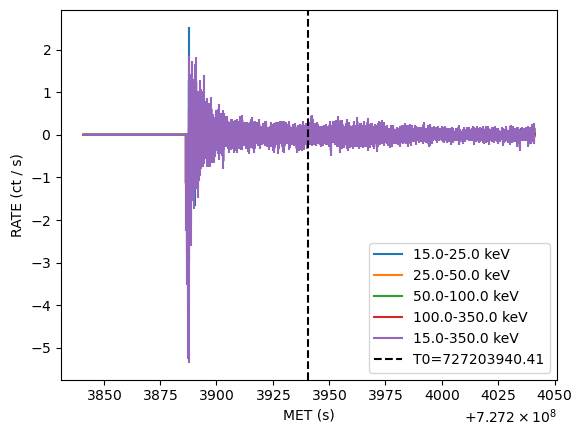

In [10]:
lc.plot(T0=triggertime.met)

The 64 ms lighcurve that we created above in 4 energy bands is very busy and is difficult to identify any sort of signal that stands out from noise. Lets modify our created lightcurve to be a single energy bin from 15-350 keV and to have 1 second time binning. Then we will plot it and try to identify any signal.

In [11]:
lc.set_energybins(emin=15*u.keV, emax=350*u.keV)


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='MET (s)', ylabel='RATE (ct / s)'>)

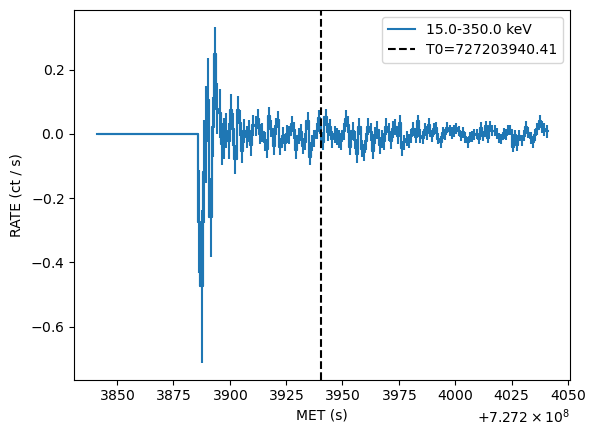

In [12]:
lc.set_timebins(timebinalg="uniform", timedelta=np.timedelta64(1, 's'))
lc.plot(T0=triggertime.met)

The lightcurve still doesn't show anything obvious. Lets try to place constraints on the flux of the FRB in the 15-150 keV energy range. We start off by creating a PHA spectrum from T0-5 to T0+5 seconds when the FRB may have produced emission. 

In [13]:
spectrum=event.create_pha(tstart=-5*u.s, tstop=5*u.s, is_relative=True, T0=triggertime.met)

We can plot this spectrum and see that there is only noise here. We can now use this spectrum to place flux upper limits on the FRB emission. 

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='E (keV)', ylabel='Count Rate (ct/s)'>)

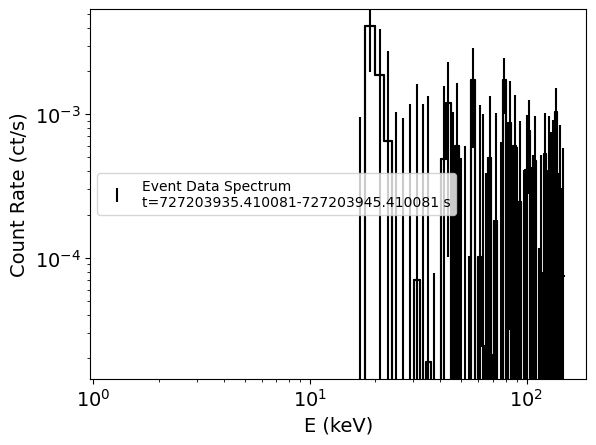

In [14]:
spectrum.plot()

We first fit the spectrum with a powerlaw. 


1 spectrum  in use
 
Spectral Data File: t_727203935.410081-727203945.410081_80chan.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  -3.960e-03 +/- 1.004e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 10 sec
 Using fit statistic: chi
 Using Response (RMF) File            t_727203935.410081-727203945.410081_80chan.rsp for Source 1


Model cflux<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      0.500000     frozen
   2    1   cflux      Emax       keV      10.0000      frozen
   3    1   cflux      lg10Flux   cgs      -12.0000     +/-  0.0          
   4    2   powerlaw   PhoIndex            1.00000      +/-  0.0          
   5    2   powerlaw   norm                1.00000      +/-  0.0          
________________________________________________________________________


Fit statistic  : Chi-Squ


***XSPEC Error:  No variable parameters for fit 
***XSPEC Error:  No variable parameters for fit 
***XSPEC Error:  No variable parameters for fit 

x   cgs      -43.8908     +/-  -1.00000     
   4    2   powerlaw   PhoIndex            7.53170      +/-  -1.00000     
   5    2   powerlaw   norm                1.00000E-03  frozen
________________________________________________________________________


Fit statistic  : C-Statistic                    2.39     using 58 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                   64.12     using 58 bins.
 Null hypothesis probability of 2.13e-01 with 56 degrees of freedom

Parameters defined:
Model cflux<1>*powerlaw<2> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   cflux      Emin       keV      15.0000      frozen
   2    1   cflux      Emax       keV      150.000      frozen
   3    1   cflux      lg10Flux   cgs      -43.8908     +/-  -1.00000     
   4    2   powerlaw   PhoIndex            7.53170      +/-  -1.00000     
   5    2   powerlaw   norm                1.00000E-03  frozen
________

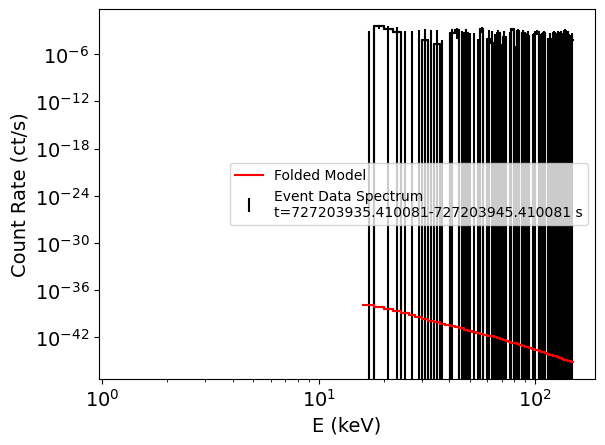

In [15]:
ba.fit_spectrum(spectrum)

Then, we pass the spectrum to the `calculate_detection` function which will confirm that we have no detection of the FRB and it will compute the 5$\sigma$ upper limit spectrum for us based on the background variation counts. The upper limit spectrum will be fitted with a powerlaw model to obtain the flux upperlimit of the FRB.  

In [16]:
upperlim_spect=ba.calculate_detection(spectrum, pl_index=1)

The condition here is 2.7530492649974766e-10 [1.0, 1.0] 3 0.0 2.7530492649974766e-10
No detection, just upperlimits for the spectrum: t_727203935.410081-727203945.410081_80chan.pha

1 spectrum  in use
 
Spectral Data File: t_727203935.410081-727203945.410081_80chan_bkgnsigma_5_upperlim.pha  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.457e-01 +/- 1.985e-02
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-80
  Telescope: SWIFT Instrument: BAT  Channel Type: PI
  Exposure Time: 10 sec
 Using fit statistic: cstat
 Using Response (RMF) File            t_727203935.410081-727203945.410081_80chan.rsp for Source 1


Fit statistic  : C-Statistic                   39.54     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                44846.80     using 80 bins.
 Null hypothesis probability of 0.00e+00 with 78 degrees of freedom
 Current data and model not fit yet.

Model powerlaw<1> Source No.: 1   Active/On
Model Model Compo

With the upper limit spectrum constructed and fitted with a simple powerlaw with a photon index of 1, we can see how the fit looks. 

80 bins.
 Null hypothesis probability of 0.00e+00 with 78 degrees of freedom
 Current data and model not fit yet.

Fit statistic  : C-Statistic                   41.98     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                44832.85     using 80 bins.
 Null hypothesis probability of 0.00e+00 with 79 degrees of freedom
 Current data and model not fit yet.

Model powerlaw<1> Source No.: 1   Active/On
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   powerlaw   PhoIndex            1.00000      frozen
   2    1   powerlaw   norm                1.00000E-03  +/-  0.0          
________________________________________________________________________

Default fit statistic is set to: C-Statistic
   This will apply to all current and newly loaded spectra.

Fit statistic  : C-Statistic      

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='E (keV)', ylabel='Count Rate (ct/s)'>)

             41.98     using 80 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                44832.85     using 80 bins.
 Null hypothesis probability of 0.00e+00 with 79 degrees of freedom
 Current data and model not fit yet.
     4 channels (1-4) ignored in spectrum #     1
    18 channels (63-80) ignored in spectrum #     1

Fit statistic  : C-Statistic                   31.74     using 58 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                34278.37     using 58 bins.
 Null hypothesis probability of 0.00e+00 with 57 degrees of freedom
 Current data and model not fit yet.


Fit statistic  : C-Statistic                    0.14     using 58 bins.

    Source file is not Poisson for spectrum 1


Test statistic : Chi-Squared                 2257.50     using 58 bins.
 Null hypothesis probability of 0.00e+00 with 57 degrees of freedom
 Current data and model not fit yet.
                                   

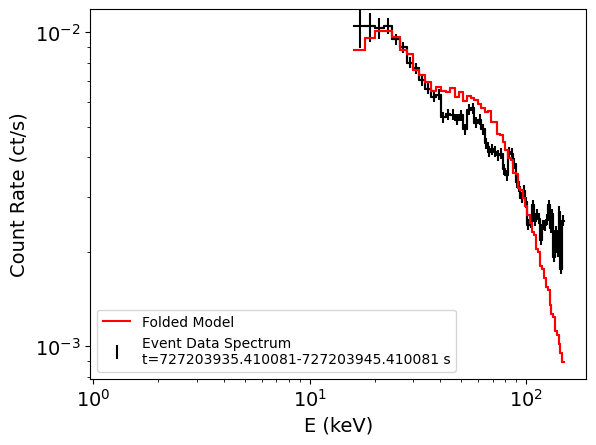

In [17]:
upperlim_spect.plot()

Lets plot the lightcurve as well as the flux upper limit that we have calculated:

(<Figure size 640x480 with 3 Axes>,
 array([<Axes: ylabel='RATE (ct / s)'>, <Axes: ylabel='flux'>,
        <Axes: xlabel='MET - T0 (T0= 727203940.410081 s)', ylabel='PhoIndex'>],
       dtype=object))

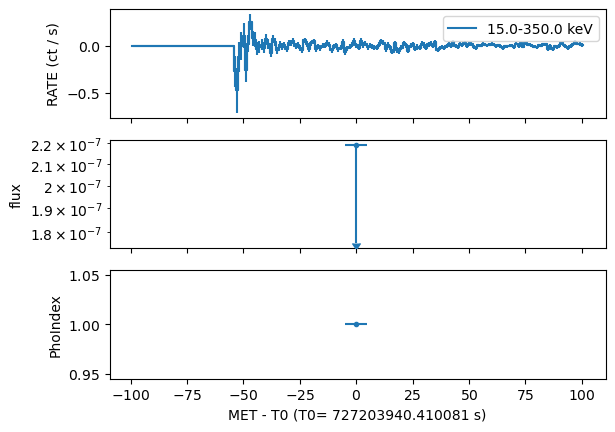

In [18]:
ba.plot_TTE_lightcurve(lc, [upperlim_spect], plot_relative=True, T0=triggertime.met)